In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib as mpl
import networkx as nx
from tqdm.notebook import tqdm
import tweepy as tw
import sqlite3
from sklearn.metrics import mean_squared_error as mse

pd.set_option('display.max_columns',500)
%matplotlib inline
seed=42
sns.set_style('whitegrid')
sns.set_context(context='paper', font_scale=2)

In [2]:
# inicializamos BD
con = sqlite3.connect('bases\example.db')
cursor = con.cursor()
data = pd.read_sql('SELECT * from relaciones', con)
print(data.shape)

print(data['nodo1'].nunique())
print(data['nodo2'].nunique())
print(data.dtypes)
nodos_unicos = data['nodo1'].append(data['nodo2']).drop_duplicates()
print('nodos únicos: ',nodos_unicos.nunique())

data = data.rename(columns={'nodo1':'seguidor','nodo2':'usuario'})

(33813, 3)
29708
64
nodo1       object
relacion    object
nodo2       object
dtype: object
nodos únicos:  29715


### Filtramos
Para tener sólo los nodos de la red inicial.

In [3]:
filtro = data['seguidor'].isin(data['usuario'].drop_duplicates())
data = data[filtro].reset_index(drop=True).copy()

# anonimizamos los usuarios
dicc_keys = data['seguidor'].drop_duplicates()
dicc_values = 'usuario_' + dicc_keys.index.astype(str).str.zfill(3)
dicc = dict(zip(dicc_keys,dicc_values))

data['seguidor_anonimo'] = data['seguidor'].replace(dicc)
data['usuario_anonimo'] = data['usuario'].replace(dicc)


print(data.shape)
data[['seguidor_anonimo','relacion','usuario_anonimo']].head(2)

(796, 5)


,seguidor_anonimo,relacion,usuario_anonimo
0,usuario_000,1.0,usuario_073
1,usuario_001,1.0,usuario_073


In [4]:
# conseguimos y pegamos los nombres de usuario para cada ID
names = pd.read_excel('recursos/red + ID.xlsx').rename(columns={'Unnamed: 0':'usuario'})
data = pd.merge(data.assign(usuario = data['usuario'].str.strip('X').apply(lambda x: int(x))), 
                names, 
                how='left', on='usuario', indicator=True)

print(data.screen_name.nunique())

data = (data.rename(columns={'screen_name':'usuario_desc'}).drop(columns=['_merge']))
dic = dict(zip(data['usuario'], data['usuario_desc']))
data['seguidor'] = data['seguidor'].str.strip('X').apply(lambda x: int(x))
data['seguidor_desc'] = data['seguidor'].replace(dic)
# data.head()

57


In [5]:
print('¿Quién es más seguido en twitter?')
display(data['usuario_anonimo'].value_counts().head(10))
print('\n¿Quién es menos seguido en twitter?')
display(data['usuario_anonimo'].value_counts().tail(10))
print('\n¿Quién es la persona que más aparece entre los seguidores de nuestra lista inicial?')
display(data['seguidor_anonimo'].value_counts().head(10))

¿Quién es más seguido en twitter?


usuario_029    44
usuario_015    36
usuario_027    35
usuario_006    35
usuario_022    35
usuario_013    32
usuario_026    31
usuario_073    30
usuario_028    27
usuario_021    27
Name: usuario_anonimo, dtype: int64


¿Quién es menos seguido en twitter?


usuario_036    5
usuario_033    4
usuario_261    3
usuario_081    3
usuario_009    3
usuario_201    2
usuario_016    2
usuario_080    2
usuario_658    1
usuario_049    1
Name: usuario_anonimo, dtype: int64


¿Quién es la persona que más aparece entre los seguidores de nuestra lista inicial?


usuario_029    43
usuario_027    41
usuario_026    32
usuario_013    32
usuario_022    31
usuario_006    29
usuario_010    28
usuario_015    27
usuario_073    26
usuario_021    25
Name: seguidor_anonimo, dtype: int64

In [6]:
#

## Creamos red

Creamos nodos y añadimos.

In [7]:
temp = data[['usuario','usuario_anonimo']].rename(columns={'usuario':'id', 'usuario_anonimo':'screen_name'})
temp = temp.append(data[['seguidor','seguidor_anonimo']].rename(columns={'seguidor':'id', 'seguidor_anonimo':'screen_name'})).reset_index(drop=True)
nodos = temp.drop_duplicates().assign(id = temp['id'].apply(lambda x: int(x)))
nodos.to_csv('recursos/nodos_unicos.csv')
nodos_dict = dict(zip(nodos['id'], nodos['screen_name']))
print(nodos.shape)

(57, 2)


In [8]:
nombres = nodos[['screen_name']].to_dict(orient='records')
nodos_G = tuple(zip(nodos['id'], nombres))
print(nodos_G[:2])

G = nx.DiGraph()
G.add_nodes_from(nodos_G)
print(nx.info(G))

((2806375215, {'screen_name': 'usuario_073'}), (245798822, {'screen_name': 'usuario_029'}))
DiGraph with 57 nodes and 0 edges


Creamos las aristas (relaciones) y añadimos.

In [9]:
seguidores = data[['seguidor','usuario']].apply(tuple, axis=1)
G.add_edges_from(seguidores, label='seguidor')
print(nx.info(G))

DiGraph with 57 nodes and 796 edges


Obtenemos muestra para graficar.

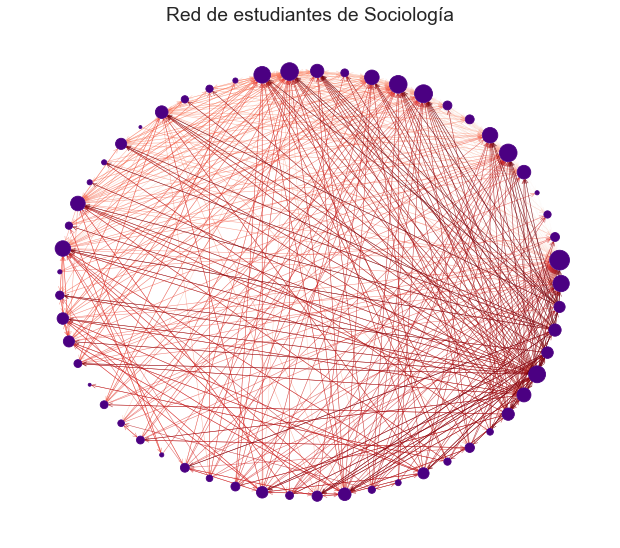

In [10]:
Gs = G.subgraph(data['usuario'].sample(60, random_state=10).tolist())
Gs = G
sizes = list(nx.in_degree_centrality(Gs).values())
sizes = [float(s) * 5e2 for s in sizes]
M = Gs.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.Reds
# cmap = plt.cm.Blues

fig,ax = plt.subplots(figsize=(9,8))
labels = nx.get_node_attributes(Gs, 'screen_name')
pos = nx.circular_layout(Gs)

nodes = nx.draw_networkx_nodes(Gs, ax=ax, pos=pos, node_size=sizes, node_color='indigo')
edges = nx.draw_networkx_edges(Gs, ax=ax, pos=pos, node_size=sizes, arrowstyle='->',
                       arrowsize=10, edge_color=edge_colors, edge_cmap=cmap, width=.5)
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])
    
pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)

ax.set_title('Red de estudiantes de Sociología')
ax = plt.gca()
ax.set_axis_off()
# cbar = plt.colorbar(pc, ax=ax, orientation='vertical', aspect=100, fraction=.05, pad=0)
# cbar.set_label('Seguidores del nodo de origen', labelpad=30, rotation=270)
plt.tight_layout()
# plt.savefig('img/resuba.png', dpi=150)

In [11]:
print(nx.info(G))

DiGraph with 57 nodes and 796 edges


### Resumen de estructura

In [12]:
def graph_metrics(red, n_round=4, nombre_red='red', nodos=nodos, printed=False):
    """
    Descripción de las métricas.
    Centralidad de grado: degree/total aristas. 
    Closeness centrality/ Cercanía: promedio de todos los shortest paths entre el nodo y sus nodos adyacentes. 
    Betweeness centrality/ Intermediación: cuánto participan los nodos en el total de "shortest path". 
    Reciprocidad: probabilidad de vinculación mutua (aristas bidireccionales / total aristas)-
    Densidad: aristas sobre posibles aristas. 
    Strongly connected: a partir de cualquier nodo se llega a cualquier nodo. 
    Clustering Coefficient: qué tan cerca está el nodo y sus vecinos de ser parte de una red completa (todos se siguen con todos). 
    """
    import networkx as nx, numpy as np, pandas as pd
    
    if printed:
        print(f'Info: {nx.info(red)}')
    
    degree_cent = nx.degree_centrality(red)
    degree_cent = np.mean(list(degree_cent.values()))
    closeness = nx.closeness_centrality(red)
    closeness = np.mean(list(closeness.values()))
    betweenness = nx.betweenness_centrality(red)
    betweenness = np.mean(list(betweenness.values())) 
    betweenness_n = nx.betweenness_centrality(red, normalized=True)
    betweenness_n = np.mean(list(betweenness_n.values()))
    reciprocidad = nx.reciprocity(red)
    densidad = nx.density(red)
    i_sc = nx.is_strongly_connected(red)
    n_sc =  nx.number_strongly_connected_components(red)
    ave_clu = nx.average_clustering(red)
    n_i = nx.number_of_isolates(red)
    prop = n_i / len(red.nodes())
    
    # armamos tabla resumen
    dic = {'nodos_q':len(nx.nodes(red)), 
          'edges_q':len(nx.edges(red)), 
          'degree_centrality_mean':degree_cent,
          'closeness_mean':closeness,
          'betweenness_mean':betweenness,
          'betweenness_norm_mean':betweenness_n,
          'reciprocity':reciprocidad,
          'density':densidad,
           'strongly_connected':i_sc,
          'strongly_connected_components':n_sc,
          'average_clustering_coefficient':ave_clu,
          'isolates':n_i, 
          'isolates_%':prop}    
    
    summary = pd.DataFrame(index=dic.keys(), data=dic.values(), columns=[nombre_red])

    # armamos tabla de centralidad
    temp = nx.in_degree_centrality(red)
    tab = pd.DataFrame(index=temp.keys(), data=temp.values(), columns=['in_degree_centrality'])
    temp = nx.out_degree_centrality(red)
    tab = tab.join(pd.DataFrame(index=temp.keys(), data=temp.values(), columns=['out_degree_centrality']))
    temp = nx.degree_centrality(red)
    tab = tab.join(pd.DataFrame(index=temp.keys(), data=temp.values(), columns=['degree_centrality']))
    
    tab = tab.assign(follower_ratio = tab['in_degree_centrality'] / tab['out_degree_centrality'])
    tab = tab.join(nodos.set_index('id')).assign(muestra = nombre_red)

    dic.update({'follower_ratio_mean':tab['follower_ratio'].replace(np.inf,np.nan).dropna().mean()})
    summary = pd.DataFrame(index=dic.keys(), data=dic.values(), columns=[nombre_red])

    # devolvemos
    return tab, summary
    
atributos, resumen = graph_metrics(G, n_round=3, nombre_red = 'estudiantes_socio')

### K-Cores
Nodos de mayor grado. 

In [13]:
len(nx.k_core(G).nodes())

20

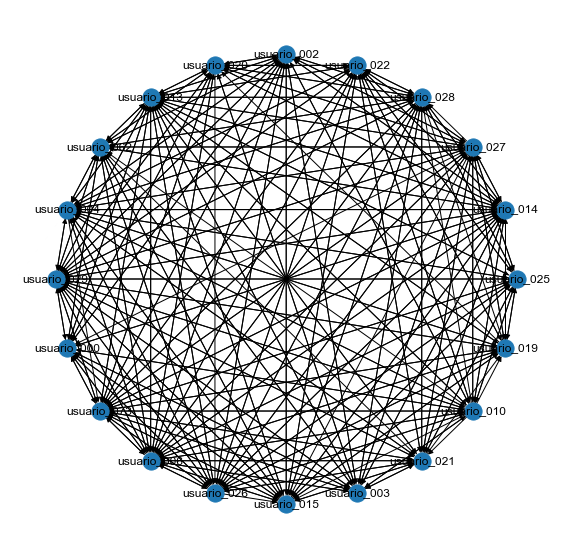

In [14]:
Gk = nx.k_core(G)
fig,ax = plt.subplots(figsize=(10,10))
labels = nx.get_node_attributes(Gk, 'screen_name')
pos = nx.circular_layout(Gk)

nx.draw(Gk, labels=labels, pos=pos, ax=ax)

## Breve análisis

In [15]:
resumen.style.format('{:.3f}')

,estudiantes_socio
nodos_q,57.000
edges_q,796.000
degree_centrality_mean,0.499
closeness_mean,0.553
betweenness_mean,0.016
betweenness_norm_mean,0.016
reciprocity,0.912
density,0.249
strongly_connected,1.000
strongly_connected_components,1.000


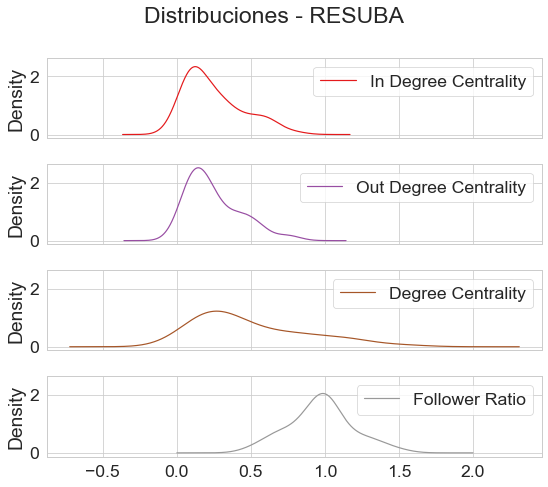

In [16]:
temp = atributos.copy()
temp.columns = [c.replace('_',' ').title() for c in atributos.columns]
temp.plot.kde(figsize=(8,7), title='Distribuciones - RESUBA', subplots=True, sharey=True, sharex=True, cmap='Set1')
plt.tight_layout();

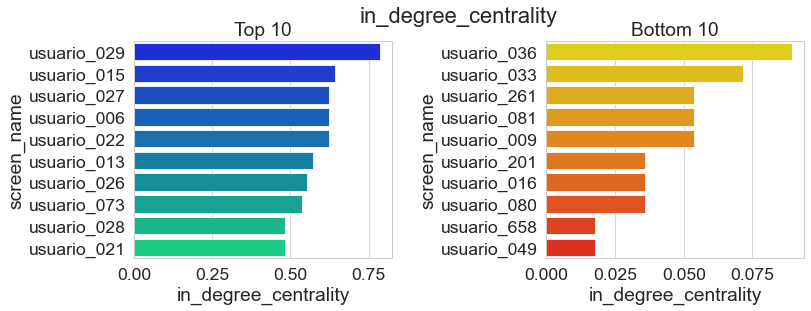

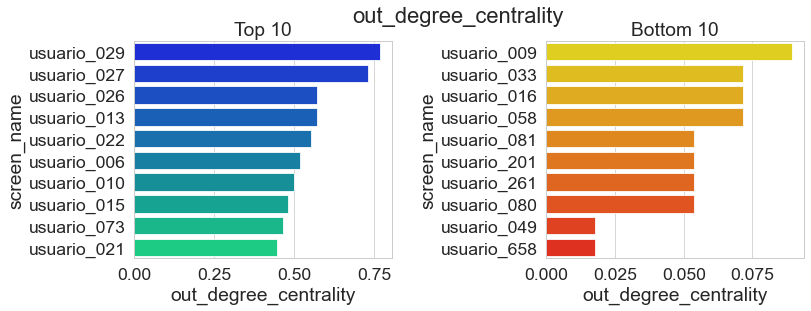

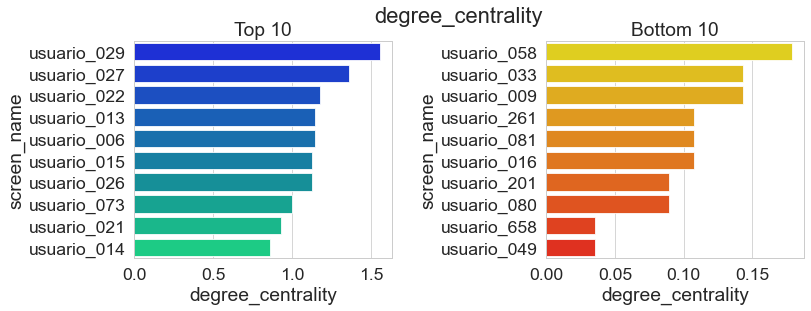

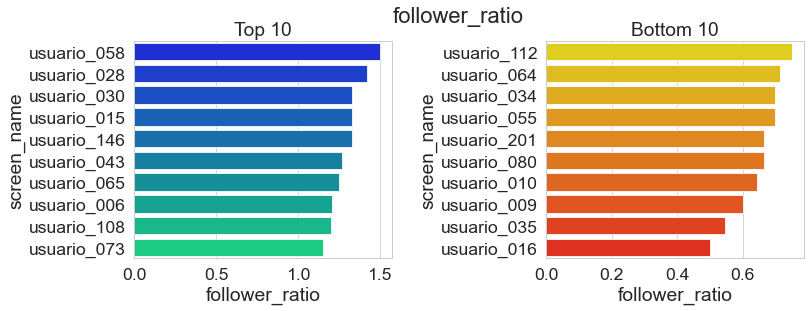

In [17]:
for col in atributos.columns[:-2]:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
    fig.suptitle(col, fontsize=22, y=1)
    plt.subplots_adjust(wspace=.6)
    sns.barplot(y='screen_name', x=col, data=atributos.sort_values(col, ascending=False).head(10), palette='winter', ax=ax1)
    ax1.set_title('Top 10')
    sns.barplot(y='screen_name', x=col, data=atributos.sort_values(col, ascending=False).tail(10), palette='autumn_r', ax=ax2)
    ax2.set_title('Bottom 10')
    plt.show()

In [18]:
#

### Remuestreo

In [19]:
def remuestreo_tw(n_inicial=5, orden=1, seed=seed, nodos=nodos, relaciones=data):
    """
    N inicial: muestra inicial aleatoria de nodos.
    Orden: qué orden de la red vamos a extraer (orden 1: seguidores de muestra inicial. Orden 2: seguidores de seguidores de muestra inicial.)
    Seed: semilla para la muestra inicial.
    Nodos: archivo de nodos (una columna con ID y otra con Screen Name).
    Relaciones: tabla de relaciones. 
    """
    nodos_iniciales = nodos['id'].sample(n_inicial, random_state=seed)
    
    # filtro
    filtro_orden1 = relaciones['usuario'].isin(nodos_iniciales)
    relaciones_muestra = relaciones[filtro_orden1].copy()

    if orden>1:
        nodos_orden1 = relaciones_muestra['seguidor'].append(nodos_iniciales).drop_duplicates()
        filtro_orden2 = relaciones['usuario'].isin(nodos_orden1)
        relaciones_muestra = relaciones[filtro_orden2].copy()
        
        if orden==3:
            nodos_orden2 = relaciones_muestra['seguidor'].append(nodos_orden1).drop_duplicates()
            filtro_orden3 = relaciones['usuario'].isin(nodos_orden2)
            relaciones_muestra = relaciones[filtro_orden3].copy()

    return relaciones_muestra

In [20]:
def build_graph(relaciones):
    """docs"""
    
    # creamos tabla de nodos
    temp = relaciones[['usuario','usuario_desc']].rename(columns={'usuario':'id', 'usuario_desc':'screen_name'})
    temp = (temp.append(relaciones[['seguidor','seguidor_desc']]
                        .rename(columns={'seguidor':'id', 'seguidor_desc':'screen_name'}))
            .reset_index(drop=True))
    tab_nodos = temp.drop_duplicates().assign(id = temp['id'].apply(lambda x: int(x)))
    
    # aladimos nodos
    nombres = tab_nodos[['screen_name']].to_dict(orient='records')
    dict_nodos = tuple(zip(tab_nodos['id'], nombres))

    red = nx.DiGraph()
    red.add_nodes_from(dict_nodos)
    
    seguidores = relaciones[['seguidor','usuario']].apply(tuple, axis=1)
    red.add_edges_from(seguidores, label='seguidor')

#     print(nx.info(red))
    
    return red

In [21]:
resultados = pd.DataFrame()
_, resumen = graph_metrics(G, n_round=3, nombre_red = 'estudiantes_socio')

seeds = [1, 3, 5, 7, 42]
for seed_n in tqdm(seeds):
    for n in tqdm(range(1,58,1), leave=False):
        for o in [1,2,3]:
            temp = remuestreo_tw(n_inicial=n, orden=o, seed = seed_n)
            filas = len(temp)
            (_, muestra_resumen) = graph_metrics(red = build_graph(temp), 
                                                 nombre_red=f'seed{seed_n} orden{o} n_inicial_{n}')
            resumen = resumen.join(muestra_resumen)
            resultados = resultados.append({'n_inicial':n, 'orden':o, 'largo':filas, 'seed':seed_n}, 
                                           ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [22]:
print(data.shape)
print(data['seguidor_desc'].nunique())
o1 = ['tomitomastomate']
fo1 = data['usuario_desc'].isin(o1)
print(data[fo1].shape)
o2 = data.loc[fo1,'seguidor_desc'].unique()
fo2 = data['usuario_desc'].isin(o2)
print(data[fo2].shape)

(796, 7)
57
(30, 7)
(580, 7)


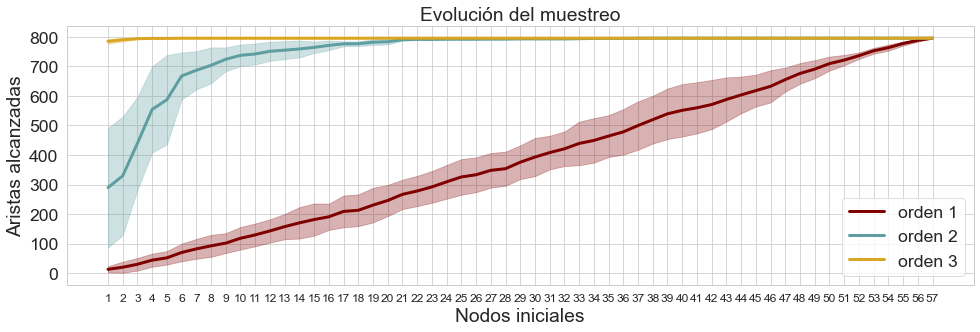

In [23]:
plot = resultados.pivot_table(index='n_inicial', columns='orden', values='largo', aggfunc=['mean','std'])
plot.columns = [''.join(str(c)).replace('(','').replace(')','').replace("'",'').replace(", ",'_').replace(".0",'') for c in plot.columns]
fig, ax = plt.subplots(figsize=(14,5))
ax.set_title('Evolución del muestreo')
ax.plot(plot.index, plot['mean_1'], color='maroon', label='orden 1', linewidth=3)
plt.fill_between(x=plot.index, y1=plot['mean_1'] + plot['std_1'], y2=plot['mean_1'] - plot['std_1'], alpha=.3, color='maroon')
ax.plot(plot.index, plot['mean_2'], color='cadetblue', label='orden 2', linewidth=3)
plt.fill_between(x=plot.index, y1=plot['mean_2'] + plot['std_2'], y2=plot['mean_2'] - plot['std_2'], alpha=.3, color='cadetblue')
ax.plot(plot.index, plot['mean_3'], color='goldenrod', label='orden 3', linewidth=3)
plt.fill_between(x=plot.index, y1=plot['mean_3'] + plot['std_3'], y2=plot['mean_3'] - plot['std_3'], alpha=.3, color='goldenrod')
x = plot.index
plt.xticks(np.arange(1, max(x)+1, 1), fontsize=12)
plt.yticks(range(0,900,100))
ax.legend(), ax.set_ylabel('Aristas alcanzadas'), ax.set_xlabel('Nodos iniciales')
plt.tight_layout()
# plt.savefig('img/muestreo_nodos.png', dpi=150, bbox='tight');

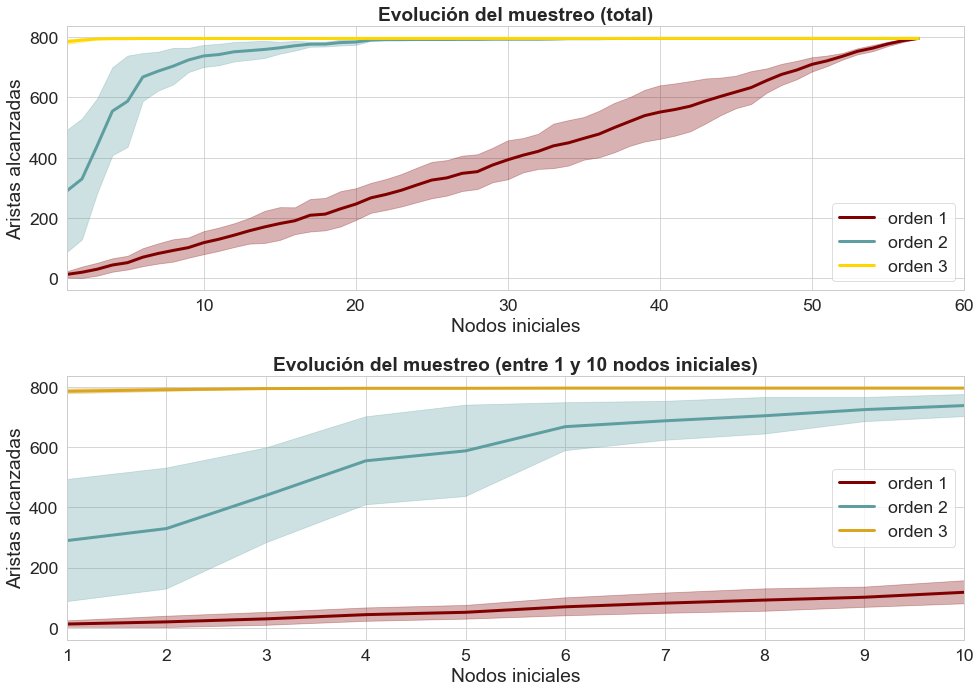

In [24]:
fig, (ax, ax2) = plt.subplots(2,1, figsize=(14,10))
ax.set_title('Evolución del muestreo (total)', fontweight='bold')
ax.plot(plot.index, plot['mean_1'], color='maroon', label='orden 1', linewidth=3)
ax.fill_between(x=plot.index, y1=plot['mean_1'] + plot['std_1'], y2=plot['mean_1'] - plot['std_1'], alpha=.3, color='maroon')
ax.plot(plot.index, plot['mean_2'], color='cadetblue', label='orden 2', linewidth=3)
ax.fill_between(x=plot.index, y1=plot['mean_2'] + plot['std_2'], y2=plot['mean_2'] - plot['std_2'], alpha=.3, color='cadetblue')
ax.plot(plot.index, plot['mean_3'], color='gold', label='orden 3', linewidth=3)
ax.fill_between(x=plot.index, y1=plot['mean_3'] + plot['std_3'], y2=plot['mean_3'] - plot['std_3'], alpha=.3, color='gold')
x = plot.index
# plt.xticks(np.arange(1, max(x)+1, 1), fontsize=12)
# plt.yticks(range(0,900,100))
ax.legend(), ax.set_ylabel('Aristas alcanzadas'), ax.set_xlabel('Nodos iniciales')
ax.set_xlim(1,60)

ax2.set_title('Evolución del muestreo (entre 1 y 10 nodos iniciales)', fontweight='bold')
ax2.plot(plot.index, plot['mean_1'], color='maroon', label='orden 1', linewidth=3)
ax2.fill_between(x=plot.index, y1=plot['mean_1'] + plot['std_1'], y2=plot['mean_1'] - plot['std_1'], alpha=.3, color='maroon')
ax2.plot(plot.index, plot['mean_2'], color='cadetblue', label='orden 2', linewidth=3)
ax2.fill_between(x=plot.index, y1=plot['mean_2'] + plot['std_2'], y2=plot['mean_2'] - plot['std_2'], alpha=.3, color='cadetblue')
ax2.plot(plot.index, plot['mean_3'], color='goldenrod', label='orden 3', linewidth=3)
ax2.fill_between(x=plot.index, y1=plot['mean_3'] + plot['std_3'], y2=plot['mean_3'] - plot['std_3'], alpha=.3, color='goldenrod')
x = plot.index
# plt.xticks(np.arange(1, max(x)+1, 1), fontsize=12)
# plt.yticks(range(0,900,100))
ax2.legend(), ax2.set_ylabel('Aristas alcanzadas'), ax2.set_xlabel('Nodos iniciales')
ax2.set_xlim(1,10)
plt.tight_layout()
# plt.savefig('img/muestreo_nodos.png', dpi=150, bbox='tight');

In [25]:
plot#.std_1.plot()

,mean_1,mean_2,mean_3,std_1,std_2,std_3
n_inicial,,,,,,
1.0,12.4,289.4,785.2,10.597169,202.704958,8.043631
2.0,19.6,329.4,790.6,18.756332,200.786703,5.941380
3.0,29.6,439.6,794.2,21.477896,157.482697,1.643168
4.0,43.6,554.4,795.2,22.255336,146.014725,0.836660
5.0,51.4,587.4,795.2,22.810085,151.640364,0.836660
6.0,69.6,667.8,795.8,29.821133,79.612813,0.447214
7.0,81.8,687.2,795.8,33.581245,64.681528,0.447214
8.0,92.0,704.0,795.8,37.195430,60.691845,0.447214
9.0,101.4,724.4,795.8,33.657094,40.128543,0.447214


In [26]:
plot['mean_2'].diff().head(30)#.plot.bar(figsize=(14,4))

n_inicial
1.0       NaN
2.0      40.0
3.0     110.2
4.0     114.8
5.0      33.0
6.0      80.4
7.0      19.4
8.0      16.8
9.0      20.4
10.0     13.4
11.0      4.6
12.0      9.2
13.0      3.8
14.0      4.0
15.0      5.4
16.0      6.8
17.0      5.2
18.0      0.4
19.0      5.0
20.0      1.8
21.0      6.6
22.0      1.2
23.0      0.0
24.0      0.6
25.0      0.0
26.0      0.0
27.0      0.4
28.0      0.0
29.0      0.8
30.0      0.0
Name: mean_2, dtype: float64

In [28]:
ordenes = ['orden1','orden2']
n_iniciales = ['n_inicial_'+str(i) for i in range(1,57)]
resumen_mean = pd.DataFrame(index = resumen.index)
resumen_std = pd.DataFrame(index = resumen.index)

for o in ordenes:
    for n in n_iniciales: 
        name = f'{o} {n}'
        cols = [c for c in resumen.columns if name + 'X' in c + 'X']
        means = resumen[cols].mean(axis=1).to_frame(name)
        stds = resumen[cols].std(axis=1).to_frame(name)
        resumen_mean = resumen_mean.join(means)
        resumen_std = resumen_std.join(stds)
        
resumen_mean = resumen_mean.T
resumen_std = resumen_std.T

In [29]:
resumen_mean['orden'] = resumen_mean.index.str.split(' ').str[0].str.replace('orden','').astype(int)
resumen_std['orden'] = resumen_std.index.str.split(' ').str[0].str.replace('orden','').astype(int)

resumen_mean['n_inicial'] = resumen_mean.index.str.split(' ').str[1].str.replace('n_inicial_','').astype(int)
resumen_std['n_inicial'] = resumen_std.index.str.split(' ').str[1].str.replace('n_inicial_','').astype(int)

In [30]:
metrics = ['nodos_q', 'edges_q', 'degree_centrality_mean', 'closeness_mean',
       'betweenness_mean', 'betweenness_norm_mean', 'reciprocity', 'density',
       'strongly_connected', 'strongly_connected_components',
       'average_clustering_coefficient', 'isolates', 'isolates_%']

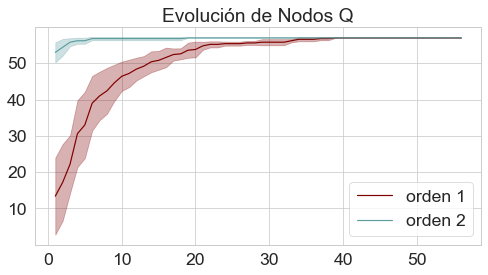

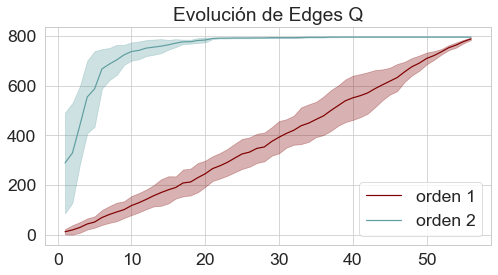

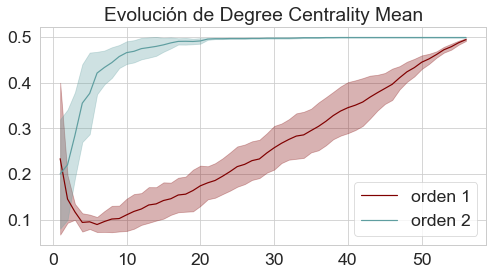

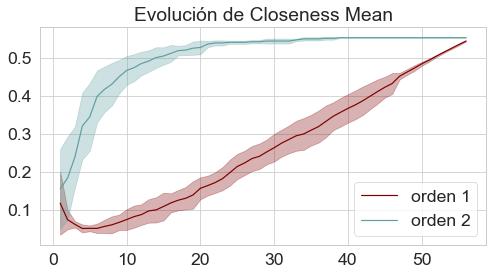

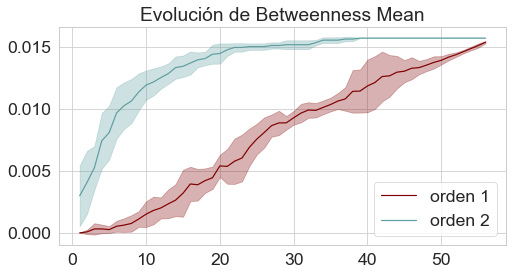

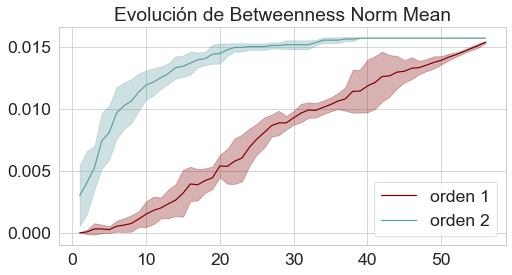

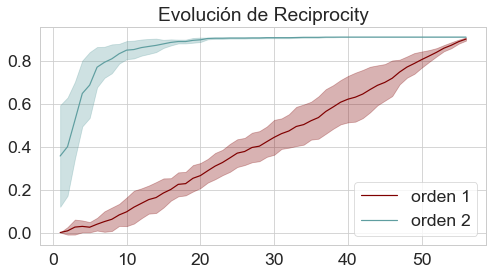

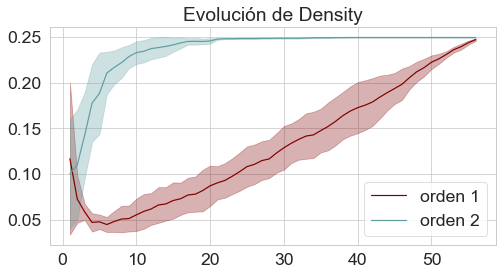

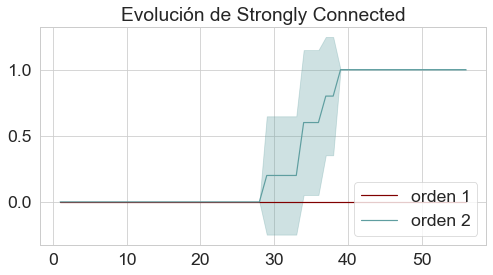

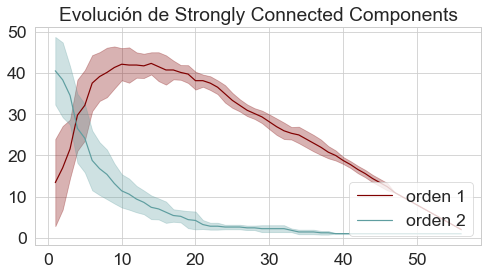

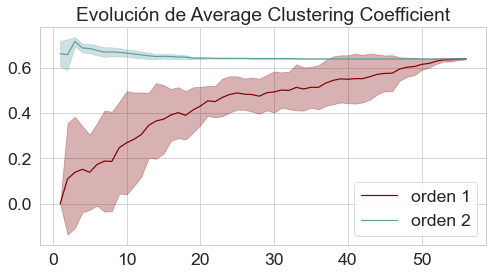

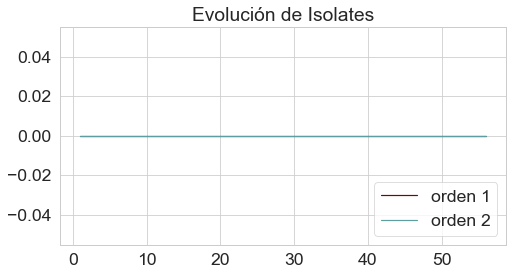

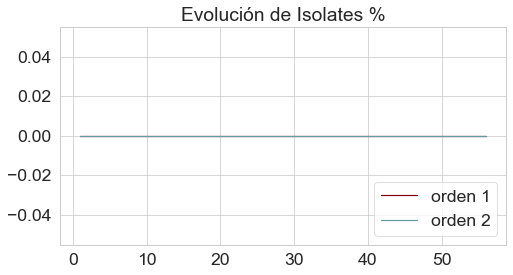

In [31]:
ordenes = [1,2]
colors = ['maroon','cadetblue']

for metric in metrics:
    fig, ax = plt.subplots(figsize=(8,4))
    
    for o, color in zip(ordenes, colors):
        filtro_m = resumen_mean['orden']==o
        filtro_s = resumen_std['orden']==o
        metric_text = metric.replace('_',' ').title()
        ax.set_title(f'Evolución de {metric_text}')
        x = resumen_mean.loc[filtro_m, 'n_inicial']
        y = resumen_mean.loc[filtro_m, metric]
        std = resumen_std.loc[filtro_s, metric]
        ax.plot(x, y, color=color, label='orden '+ str(o))
        plt.fill_between(x, y+std, y-std, alpha=.3, color=color)
        ax.legend(loc='lower right')
    
    plt.show();

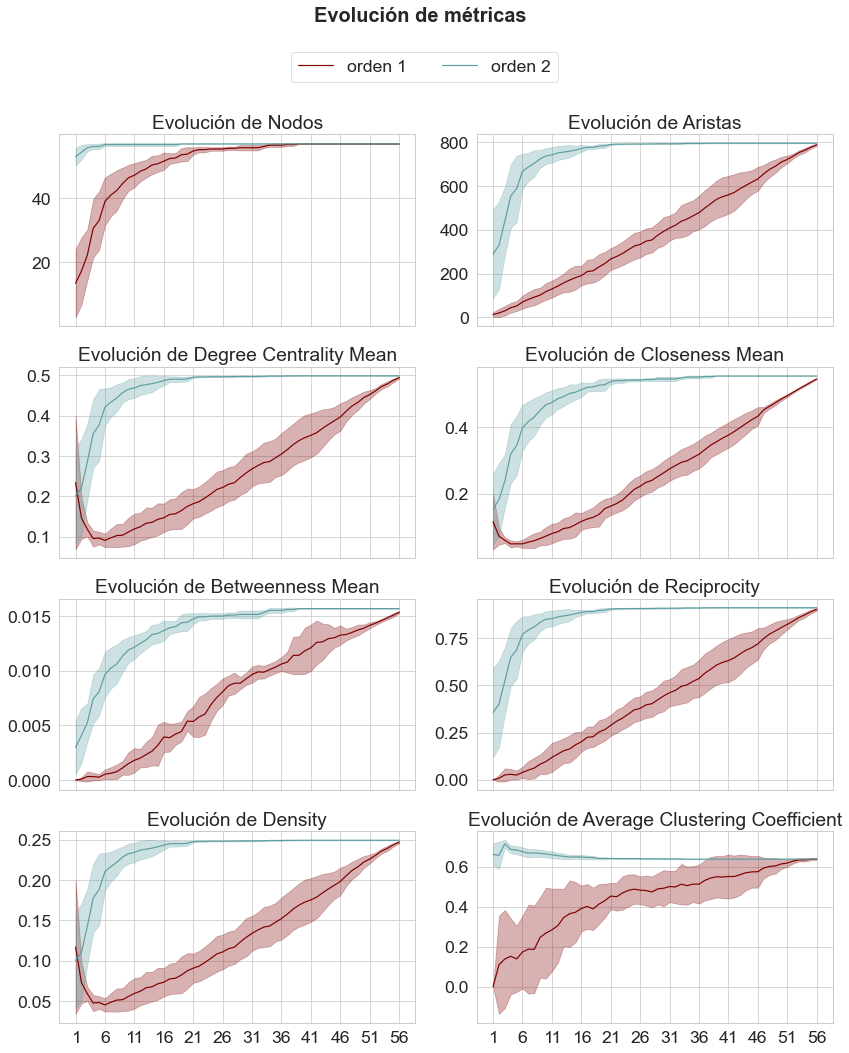

In [32]:
metrics_grid = ['nodos_q', 'edges_q', 'degree_centrality_mean', 'closeness_mean', 'betweenness_mean',
               'reciprocity', 'density','average_clustering_coefficient',
#                 'strongly_connected', 'strongly_connected_components'
               ]
ordenes = [1,2]
colors = ['maroon','cadetblue']

fig, axes = plt.subplots(4,2, figsize=(12,14), sharex=True)
axes = axes.flatten()

for metric, ax in zip(metrics_grid,axes):
    
    for o, color in zip(ordenes, colors):
        filtro_m = resumen_mean['orden']==o
        filtro_s = resumen_std['orden']==o
        metric_text = metric.replace('_',' ').replace(' q','').replace('edges','aristas').title()
        ax.set_title(f'Evolución de {metric_text}')
        x = resumen_mean.loc[filtro_m, 'n_inicial']
        y = resumen_mean.loc[filtro_m, metric]
        std = resumen_std.loc[filtro_s, metric]
        ax.plot(x, y, color=color, label='orden '+ str(o))
        ax.fill_between(x, y+std, y-std, alpha=.3, color=color)
        
plt.xticks(np.arange(min(x), max(x)+2, 5))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2,borderaxespad = 3)
fig.suptitle('Evolución de métricas', y=1.05, fontsize=20, fontweight='bold')
plt.tight_layout(pad=1)
plt.savefig('img/muestreo_metricas.png', dpi=150, bbox_inches='tight');

Vamos a hacer el análisis con 4 casos. Viendo el crecimiento de todos los puntos, tomaremos los siguientes casos de n_inicial: 1, 5, 10, 20. 

In [33]:
atrr_1_1,_ = graph_metrics(red = build_graph(remuestreo_tw(n_inicial=1, orden=1)), nombre_red=f'orden{1} n_inicial_{1}')
atrr_2_1,_ = graph_metrics(red = build_graph(remuestreo_tw(n_inicial=1, orden=2)), nombre_red=f'orden{2} n_inicial_{1}')

atrr_1_5,_ = graph_metrics(red = build_graph(remuestreo_tw(n_inicial=5, orden=1)), nombre_red=f'orden{1} n_inicial_{5}')
atrr_2_5,_ = graph_metrics(red = build_graph(remuestreo_tw(n_inicial=5, orden=2)), nombre_red=f'orden{2} n_inicial_{5}')

atrr_1_10,_ = graph_metrics(red = build_graph(remuestreo_tw(n_inicial=10, orden=1)), nombre_red=f'orden{1} n_inicial_{10}')
atrr_2_10,_ = graph_metrics(red = build_graph(remuestreo_tw(n_inicial=10, orden=2)), nombre_red=f'orden{2} n_inicial_{10}')

atrr_1_20,_ = graph_metrics(red = build_graph(remuestreo_tw(n_inicial=20, orden=1)), nombre_red=f'orden{1} n_inicial_{20}')
atrr_2_20,_ = graph_metrics(red = build_graph(remuestreo_tw(n_inicial=20, orden=2)), nombre_red=f'orden{2} n_inicial_{20}')

atrr_3_1,_ = graph_metrics(red = build_graph(remuestreo_tw(n_inicial=1, orden=3)), nombre_red=f'orden{3} n_inicial_{1}')

In [34]:
atributos_completo = (atributos
                      .append(atrr_1_1).append(atrr_2_1)
                      .append(atrr_1_5).append(atrr_2_5)
                      .append(atrr_1_10).append(atrr_2_10)
                      .append(atrr_1_20).append(atrr_2_20)
                      .append(atrr_3_1)
                     .replace(0,np.nan))

atributos_completo['orden'] = 3
atributos_completo['orden'] = np.where(atributos_completo['muestra'].str.contains('orden1'),1,2)
atributos_completo['n_inicial'] = atributos_completo['muestra'].str.extract('n_inicial_(\d*)').fillna(57).astype(int).values
atributos_completo = atributos_completo.sort_values('orden')

pd.crosstab(atributos_completo.muestra, atributos_completo.n_inicial)

n_inicial,1,5,10,20,57
muestra,,,,,
estudiantes_socio,0,0,0,0,57
orden1 n_inicial_1,31,0,0,0,0
orden1 n_inicial_10,0,0,45,0,0
orden1 n_inicial_20,0,0,0,51,0
orden1 n_inicial_5,0,39,0,0,0
orden2 n_inicial_1,57,0,0,0,0
orden2 n_inicial_10,0,0,57,0,0
orden2 n_inicial_20,0,0,0,57,0
orden2 n_inicial_5,0,57,0,0,0


In [35]:
print(all(resumen_mean.index == resumen_std.index))
filtro = (resumen_mean.index + 'X').str.contains('n_inicial_1X')
filtro |= (resumen_mean.index + 'X').str.contains('n_inicial_4X')
filtro |= (resumen_mean.index + 'X').str.contains('n_inicial_7X')
filtro |= (resumen_mean.index + 'X').str.contains('n_inicial_20X')
filtro |= (resumen_mean.index + 'X').str.contains('orden3')
filtro |= (resumen_mean.index + 'X').str.contains('orden2 n_inicial_40X')

tab = resumen_mean[filtro].T
tab.style.background_gradient(axis=1).format('{:.3f}')

True


,orden1 n_inicial_1,orden1 n_inicial_4,orden1 n_inicial_7,orden1 n_inicial_20,orden2 n_inicial_1,orden2 n_inicial_4,orden2 n_inicial_7,orden2 n_inicial_20,orden2 n_inicial_40
nodos_q,13.400,30.600,41.000,53.800,53.000,56.200,56.800,57.000,57.000
edges_q,12.400,43.600,81.800,245.800,289.400,554.400,687.200,784.000,796.000
degree_centrality_mean,0.234,0.095,0.097,0.175,0.201,0.355,0.433,0.491,0.499
closeness_mean,0.117,0.050,0.056,0.156,0.154,0.320,0.416,0.527,0.553
betweenness_mean,0.000,0.000,0.001,0.005,0.003,0.007,0.010,0.014,0.016
betweenness_norm_mean,0.000,0.000,0.001,0.005,0.003,0.007,0.010,0.014,0.016
reciprocity,0.000,0.029,0.051,0.266,0.357,0.649,0.794,0.899,0.912
density,0.117,0.047,0.048,0.087,0.100,0.178,0.217,0.246,0.249
strongly_connected,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
strongly_connected_components,13.400,29.800,39.200,38.200,40.600,26.600,16.800,4.200,1.000


In [36]:
# obtenemos métrica resumen
metrics = [ 'degree_centrality_mean', 'closeness_mean','betweenness_mean', 'reciprocity',
        'density','strongly_connected_components','average_clustering_coefficient', 'follower_ratio_mean']

metrics = [ 'degree_centrality_mean', 'closeness_mean','betweenness_mean', 'reciprocity',
        'density','average_clustering_coefficient', 'follower_ratio_mean']

filtro = tab.index.isin(metrics)
parametro = tab.loc[filtro, 'orden2 n_inicial_40']

errores = []
muestras = []
for c in tab.columns:
    muestras = muestras + [c]

    error = ((tab.loc[filtro, c] - parametro) / parametro).mean()
    error = mse(parametro, tab.loc[filtro,c])
    errores = errores + [error]
    
pd.DataFrame(data=errores, index=muestras, columns=['Error']).T.style.format('{:.4f}')

,orden1 n_inicial_1,orden1 n_inicial_4,orden1 n_inicial_7,orden1 n_inicial_20,orden2 n_inicial_1,orden2 n_inicial_4,orden2 n_inicial_7,orden2 n_inicial_20,orden2 n_inicial_40
Error,0.3514,0.2240,0.2080,0.1123,0.0981,0.0296,0.0094,0.0004,0.0000


In [37]:
tab.pct_change(axis=1).replace(np.nan,0).replace(np.inf, 0).style.background_gradient(axis=1).format('{:.1%}')

,orden1 n_inicial_1,orden1 n_inicial_4,orden1 n_inicial_7,orden1 n_inicial_20,orden2 n_inicial_1,orden2 n_inicial_4,orden2 n_inicial_7,orden2 n_inicial_20,orden2 n_inicial_40
nodos_q,0.0%,128.4%,34.0%,31.2%,-1.5%,6.0%,1.1%,0.4%,0.0%
edges_q,0.0%,251.6%,87.6%,200.5%,17.7%,91.6%,24.0%,14.1%,1.5%
degree_centrality_mean,0.0%,-59.5%,2.1%,80.5%,14.8%,77.1%,21.9%,13.3%,1.5%
closeness_mean,0.0%,-57.0%,10.7%,180.5%,-1.1%,107.2%,30.2%,26.5%,4.9%
betweenness_mean,0.0%,0.0%,96.4%,767.1%,-44.7%,148.6%,38.0%,41.1%,8.6%
betweenness_norm_mean,0.0%,0.0%,96.4%,767.1%,-44.7%,148.6%,38.0%,41.1%,8.6%
reciprocity,0.0%,0.0%,78.3%,418.6%,34.4%,81.7%,22.4%,13.2%,1.4%
density,0.0%,-59.5%,2.1%,80.5%,14.8%,77.1%,21.9%,13.3%,1.5%
strongly_connected,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
strongly_connected_components,0.0%,122.4%,31.5%,-2.6%,6.3%,-34.5%,-36.8%,-75.0%,-76.2%


## Nube de palabras. 

In [38]:
with open('recursos\Tomi B keys.txt') as f:
    consumer_key_2 = f.readline().split('"')[1]
    consumer_secret_2 = f.readline().split('"')[1]
    access_key_2 = f.readline().split('"')[1]
    access_secret_2 = f.readline().split('"')[1]
    
# Credenciales Tomi 

auth = tw.OAuthHandler(consumer_key_2, consumer_secret_2)
auth.set_access_token(access_key_2, access_secret_2)
api_b = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)    
api = api_b

In [39]:
def extract_tweet_info(tweet):
    """docs"""
    idx = tweet.id_str
    tw_dic = {
        'user':username,
        'created_at':tweet.created_at,
         'id_str':idx,
         'text':tweet.full_text, 
         'source':tweet.source, 
         'source_url':tweet.source_url,
         'in_reply_to_screen_name':tweet.in_reply_to_screen_name,
         'in_reply_to_user_id_str':tweet.in_reply_to_user_id_str,
         'in_reply_to_status_id_str':tweet.in_reply_to_status_id_str ,
         'user.screen_name':tweet.user.screen_name,
         'geo':tweet.geo,
         'lang':tweet.lang,
         'coordinates':tweet.coordinates,
         'place':tweet.place,
         'is_quote_status':tweet.is_quote_status,
          'retweet_count':tweet.retweet_count,
          'favorite_count':tweet.favorite_count
    }
    
    return tw_dic

def build_tweets_df(tweets_list):
    """docs"""
    import pandas as pd
    from tqdm.notebook import tqdm

    df = []
    
    for tweet in tweets_list:
        tw_dic = extract_tweet_info(tweet)
        df = df + [tw_dic]
        
    df = pd.DataFrame(df)
    return df

In [40]:
# df_tweets = pd.DataFrame()
# errors = []
# for username in tqdm(names.screen_name.unique()):
#     try:
#         lista = api.user_timeline(username, count=200, tweet_mode='extended') # Get the last tweet
#         temp = build_tweets_df(lista)
#         df_tweets = df_tweets.append(temp)
#     except:
#         errors = errors + [username]

In [41]:
# df_tweets.to_excel('recursos/221009_tweets.xlsx')
# df_tweets.to_csv('recursos/221009_tweets.csv')

In [42]:
df_tweets = pd.read_excel('recursos/221009_tweets.xlsx')
print(df_tweets.shape)
display(df_tweets.head(2))

(13142, 18)


,Unnamed: 0,user,created_at,id_str,text,source,source_url,in_reply_to_screen_name,in_reply_to_user_id_str,in_reply_to_status_id_str,user.screen_name,geo,lang,coordinates,place,is_quote_status,retweet_count,favorite_count
0,0,tomitomastomate,2022-10-08 00:59:10,1578550535879172096,@ludelorvuelve Es que ellos lo dicen con gracia,Twitter Web App,https://mobile.twitter.com,ludelorvuelve,1.004335e+18,1.578542e+18,tomitomastomate,NaN,es,NaN,NaN,False,0,1
1,1,tomitomastomate,2022-10-07 13:23:44,1578375525550108672,@AnitaSicilia Si no sacan la foto como los ver...,Twitter Web App,https://mobile.twitter.com,AnitaSicilia,1.600721e+08,1.578374e+18,tomitomastomate,NaN,es,NaN,NaN,False,0,0


In [43]:
import nltk, unidecode
# nltk.download()
from wordcloud import WordCloud
%matplotlib inline

In [44]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))
add = ['https','el','rt','la','si','lo','hace','hacer','gt',
       'cada','vez','puede','ser','puedo','creer','va','ser','tal','vez' # expresiones
      ]
for i in add:
    stop_words.add(i)

In [45]:
text = ' '.join(df_tweets.text.str.lower().apply(lambda x: unidecode.unidecode(x)))
tokens = word_tokenize(text)

words = [word for word in tokens if word.isalpha()]
words = [w for w in words if not w in stop_words]
# stemmed = [porter.stem(word) for word in tokens]

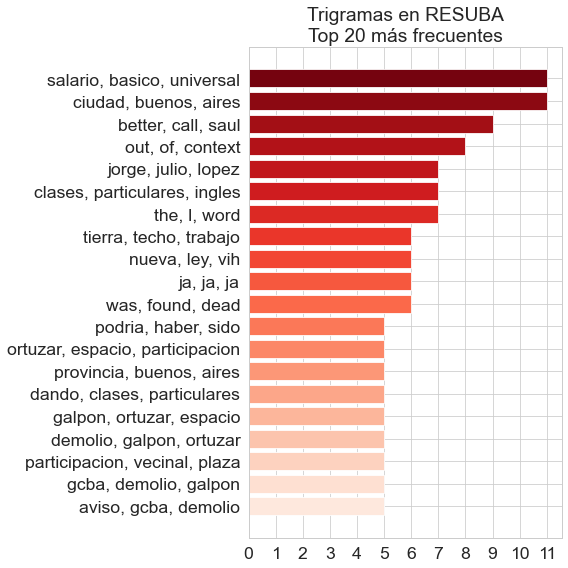

In [46]:
true_tigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20].sort_values().to_frame('q')
true_tigrams_series.index = [', '.join(i) for i in true_tigrams_series.index]

cmap = mpl.cm.get_cmap('Reds')

colors = []
for i in range(20, cmap.N, int(cmap.N/20)):
    colors = colors + [cmap(i)]
    
title = 'Trigramas en RESUBA\nTop 20 más frecuentes'
fig, ax = plt.subplots(figsize=(8,8))
ax.barh(y=true_tigrams_series.index, width=true_tigrams_series.q, color=colors)
ax.set_xticks(range(0, max(true_tigrams_series['q'])+1)), ax.set_title(title)
plt.tight_layout()
# plt.savefig('img/resuba_trigramas.png', dpi=150);

# Count


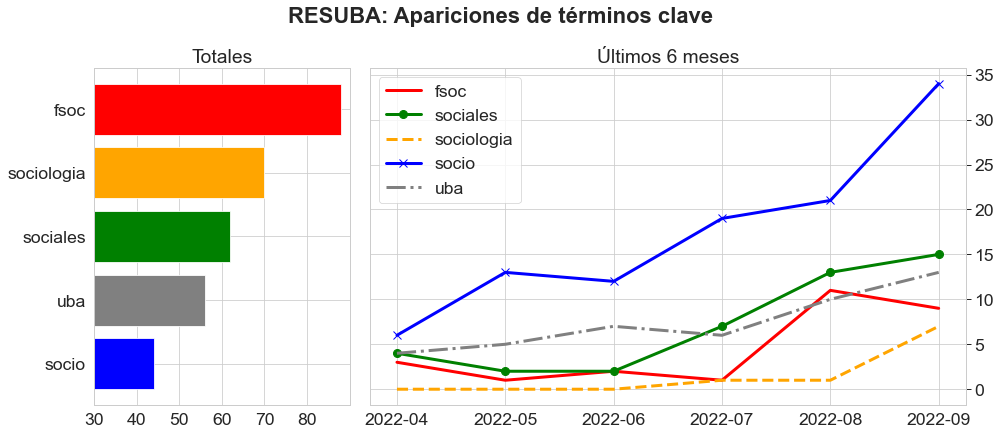

In [47]:
key_words = ['fsoc','sociales','sociologia','socio','uba']
filtro = df_tweets['created_at'] > '2022-01-01'
fecha = df_tweets['created_at'].dt.year.astype(str) + '-' + df_tweets['created_at'].dt.month.astype(str).str.zfill(2)
df_key = df_tweets.loc[filtro, ['text']].assign(fecha = fecha)

print('# Count')
count = []
for key in key_words:
    c = words.count(key)
    count = count + [c]
#     print(f'{key}: {c}')
    
    df_key[key] = df_key['text'].str.contains(key).fillna(False).replace(True,1).replace(False,0)
    
    
fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 7]}, figsize=(14,6))

fig.suptitle('RESUBA: Apariciones de términos clave', fontsize=22, y=1, fontweight='bold')

df_count = (pd.DataFrame(index=key_words, data=count, columns=['q'])).sort_values('q')
colors = ['b','gray','g','orange','r']
a0.barh(y=df_count.index, width=df_count.q, color=colors)
a0.set_title('Totales'), a0.set_xlim(min(count)-14, max(count)+2)
a0.set_xticks(np.arange(min(count)-14, max(count)+2, 10))

colors = ['r','g','orange','b','gray']
title = 'Últimos 6 meses'
df_key.groupby('fecha').sum().head(9).tail(6).dropna().plot(title=title, xlabel='', ax=a1, linewidth=3, 
                                                            color=colors, markersize=8,
                                                            style=['-','o-','--','x-','-.'])
a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
fig.tight_layout()
# plt.savefig('img/resuba_keywords.png', dpi=150);